<a href="https://colab.research.google.com/github/tibebu-sime/sales-predictions/blob/main/salespredictions_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Task**
The aim of this project is to build a sales prediction model for a retail store and forecast the sales of each product at a particular outlet. It is based on historical sales data which were collected for 1559 products sold across 10 stores located in different cities.  

**Attributes information:**
1. Item_Identifier: Unique product ID
2. Item_Weight: Weight of product
3. Item_Fat_Content: Whether the product is low fat or not
4. Item_Visibility: The % of total display area of all products in a store allocated to the particular product
5. Item_Type: The category to which the product belongs
6. Item_MRP: Maximum Retail Price (list price) of the product
7. Outlet_Identifier: Unique store ID
8. Outlet_Establishment_Year: The year in which store was established
9. Outlet_Size: The size of the store in terms of ground area covered
10. Outlet_Location_Type: The type of city in which the store is located. Tier1 cities are densely populated and have higher living expenses.
11. Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket
12. Item_Outlet_Sales: Sales of the product in the particular store. This is the outcome variable to be predicted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
filename = '/content/drive/MyDrive/CodingDojo/Week2_PandasforDataManipulation/Exercises_and_Homework/sales_predictions.csv'
sales_data = pd.read_csv(filename)
sales_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##**Exploratory Data Analysis**

In [ ]:
# The summary of the dataset 
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


***Checking for missing values in the dataset:***

Check and detect the presence of missing values using the isnull() function.
References: 
1. https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
2. https://jamesrledoux.com/code/imputation
3. https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas
4. https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

In [ ]:
sales_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Based on the results above, there are missing values within two columns, namely Item_Weight and Outlet_Size. I will be filling the missing values within the Item_Weight column by the mean of this same column but imputing the missing values within the Outlet_Size column using the Most Freuquent Imputation technique which works well with both strings or categorical features and numerical representations.  


In [ ]:
# Fill the null values within the Item_Weight column with the mean of this column
sales_data['Item_Weight'] = sales_data['Item_Weight'].fillna(sales_data['Item_Weight'].mean())
sales_data.head()

In [ ]:
# Only the Outlet Size column has missing values. Impute them with most frequent values
# https://www.geeksforgeeks.org/how-to-fill-nan-values-with-mean-in-pandas/

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
fitted_data = imputer.fit_transform(sales_data) # Returns NumPy array 

sales_data = pd.DataFrame(fitted_data, index=sales_data.index, columns=sales_data.columns)
sales_data.head()


In [ ]:
# Double checking the presence of missing values
sales_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
# Checking the number of unique appearances of observations within each column in the dataset 
sales_data.apply(lambda x: x.nunique())

Item_Identifier              1559
Item_Weight                   416
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

***Checking data entry inconsistencies***

Since there are data entry inconsistencies in the Item_Fat_Content, they need to be replaced.

In [ ]:
sales_data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)
sales_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

##**Data Visualization**

In [ ]:
# Changing the data types of the columns whose data types have been modified when
# the missing values in the Outlet_Size column were imputed. 
# Reference: https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

sales_data = sales_data.astype({'Item_Weight': float, 
                                'Item_Visibility': float,
                                'Item_MRP': float,
                                'Outlet_Establishment_Year': int,
                                'Item_Outlet_Sales': float
                                               })

In [ ]:
# Double checking the data types 
sales_data.dtypes 

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
# Displaying the descriptive statistics of the numerical variables
sales_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Item_Weight,8523.0,12.857645,4.226124,4.555,9.310000,12.857645,16.000000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


***Generating Correlation Matrix***

The correlation between numerical features and the target vector will be plotted using heatmaps. 

In [ ]:
correlation = sales_data.corr()
correlation.sort_values(by='Item_Outlet_Sales') # Sort them by the Sales

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Visibility,-0.012049,1.000000,-0.001315,-0.074834,-0.128625
Outlet_Establishment_Year,-0.008301,-0.074834,0.005020,1.000000,-0.049135
Item_Weight,1.000000,-0.012049,0.024756,-0.008301,0.011550
Item_MRP,0.024756,-0.001315,1.000000,0.005020,0.567574
Item_Outlet_Sales,0.011550,-0.128625,0.567574,-0.049135,1.000000


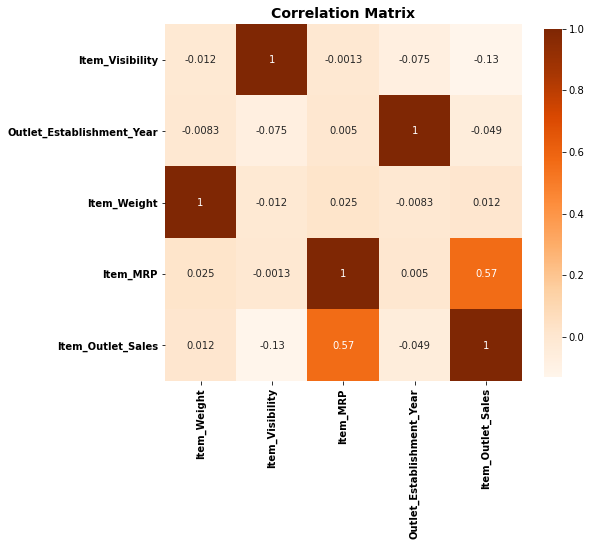

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(correlation.sort_values(by='Item_Outlet_Sales'),
            square=True, 
            cmap='Oranges', 
            cbar_kws={"shrink": .8},
            annot=True)
plt.title('Correlation Matrix', fontdict={'size': 14, 'fontweight': 'bold'})
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

From the heatmap above, we can observe that:
1. There is a moderate positive relationship between the Item_MRP and Item_Outlet_Sales as the correlation coefficient is equal to 0.57. 
2. The Item_Weight has very low positive correlation with the target vector. It may be diffcult to spot the relationship between them.
3. The Item_Visibility feature has the lowest negative correlation with the target vector. Hence, the less visible the product is in the store the higher the price will be.

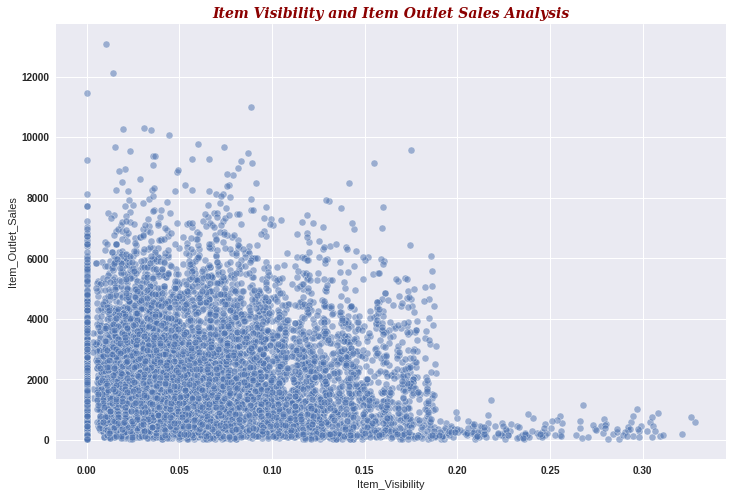

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkRed'
        }
plt.figure(figsize=(12, 8))
sns.scatterplot(sales_data['Item_Visibility'], sales_data['Item_Outlet_Sales'], alpha=0.5)
plt.title('Item Visibility and Item Outlet Sales Analysis', fontdict=font)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

The scatter plot above and the first correlation indicate that more visible products have less sales than the less visible ones. This might be due to the fact that a great number of daily consumed products which do not need that much high visibility are highly stocked the shelves so that they control the top of the sales chart. 


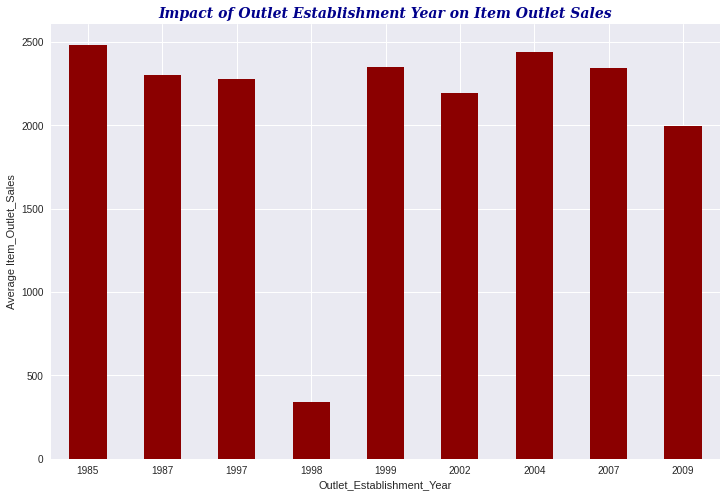

In [ ]:
plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
sales_year= sales_data.groupby('Outlet_Establishment_Year')[['Item_Outlet_Sales']].mean()
sales_year.plot.bar(color='darkred', figsize=(12, 8))
plt.title('Impact of Outlet Establishment Year on Item Outlet Sales', fontdict=font)
plt.xticks(rotation=0)
plt.ylabel('Average Item_Outlet_Sales')
plt.legend('')
plt.show()

From the bar chart, we can see that except for the year 1998 which has the lowest average sales, the distribution of average sales is almost the same for each year. So it seems that the year of Outlet establishment has no that much significant impact on the sales as there is very low negative correlation between them. 

***Visualizing the distribution of the Item Outlet Sales***

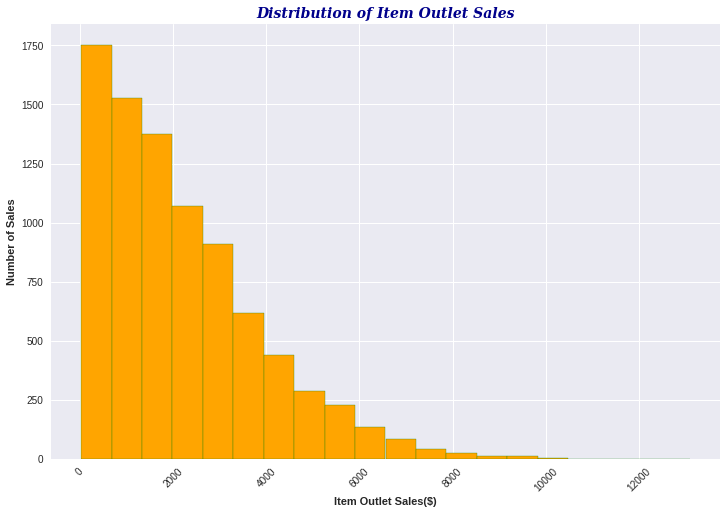

In [ ]:
# Visualize the distribution of the item outlet sales of the target vector 
sales_data['Item_Outlet_Sales'].hist(bins=20, color='orange', edgecolor='green', figsize=(12, 8))
plt.xticks(rotation=45)
plt.ticklabel_format(useOffset=False, style='plain')

font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

plt.xlabel('Item Outlet Sales($)', fontweight='bold')
plt.ylabel('Number of Sales', fontweight='bold')
plt.title('Distribution of Item Outlet Sales', fontdict=font)
plt.show()

From the graph, we can see that the sales distribution deviates from the normal distribution and is skewed to the right, with higher concentration on the lower sales. 

***Visualizing distribution of Item Types in the store***

Reference: https://seaborn.pydata.org/generated/seaborn.countplot.html

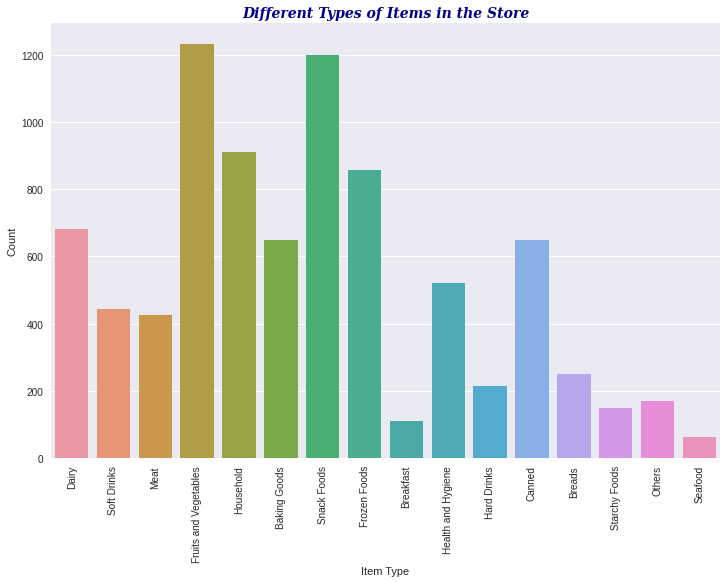

In [ ]:
# Different types of items available in the store 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
plt.style.use('seaborn')

font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

plt.figure(figsize=(12, 8))
sns.countplot(sales_data['Item_Type'])
plt.title('Different Types of Items in the Store', fontdict=font)
plt.xticks(rotation=90)
plt.xlabel('Item Type')
plt.ylabel('Count')
plt.show()

From the graph, we can see that there are 16 types of unique items with fruits and vegetables,and snack foods are the most abundantly available products in the store. 

***Visualizing the distribution of Outlet Location Type***

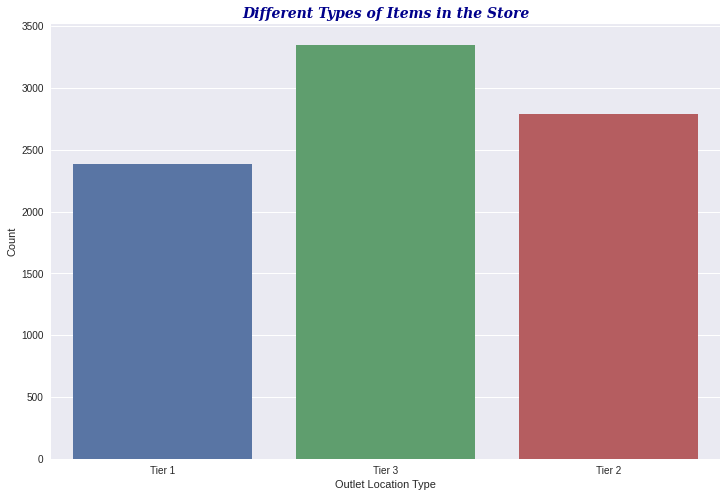

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

plt.figure(figsize=(12, 8))
sns.countplot(sales_data['Outlet_Location_Type'])
plt.title('Different Types of Items in the Store', fontdict=font)
plt.xlabel('Outlet Location Type')
plt.ylabel('Count')
plt.show()

From the graph above, we can see that the store is highly present in small and medium cities rather than the densely populated ones.

***Visualizing the distribution of Outlet Type***

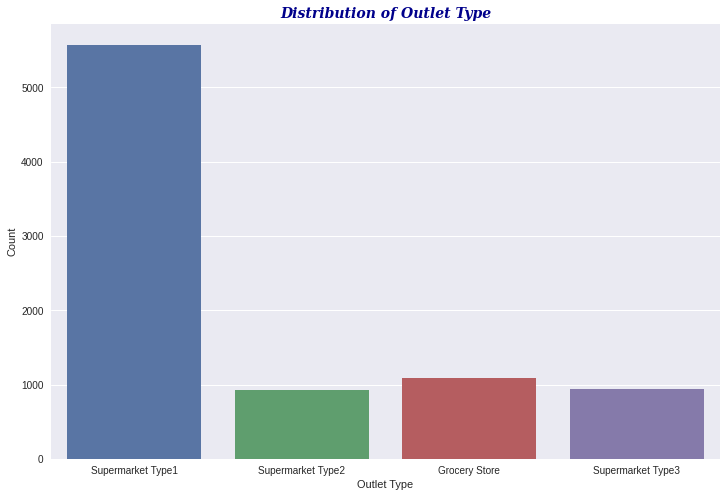

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

plt.figure(figsize=(12, 8))
sns.countplot(sales_data['Outlet_Type'])
plt.title('Distribution of Outlet Type', fontdict=font)
plt.xlabel('Outlet Type')
plt.ylabel('Count')
plt.show()

From the graph above, we can observe that Supermarket Type2, Grocery Store and Supermarket Type3 have all low number of counts in the distribution. Supermarket Type1 is widely available.  

***Visualizing the distribution of average Item Sales by the store location types and the store types***

In [ ]:
# the average item sales by the store location types 
sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()

In [ ]:
# the average item sales by the store types  
sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()

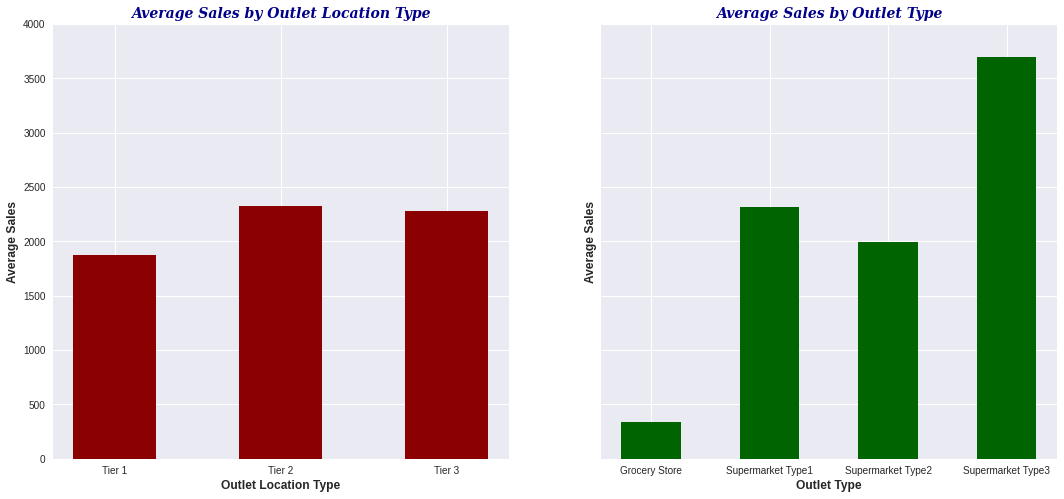

In [ ]:
x0 = sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().index
y0 = sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().values

x1 = sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().index
y1 = sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().values

plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 8))
axs[0].bar(x0, y0, width=0.5, color='darkred')
axs[0].set_title('Average Sales by Outlet Location Type', fontdict=font)
axs[0].set_ylim(0, 2500)
#Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tick_params.html
axs[0].tick_params(axis='both', labelsize=10)  
axs[0].set_xlabel('Outlet Location Type', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Average Sales', fontsize=12, fontweight='bold')

axs[1].bar(x1, y1, width=0.5, color='darkgreen')
axs[1].set_title('Average Sales by Outlet Type', fontdict=font)
axs[1].set_ylim(0, 4000)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_xlabel('Outlet Type', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Average Sales', fontsize=12, fontweight='bold')

plt.show()

From the graphs above:
1. we can see that more sales are being made in the stores which are found in less densely populated cities because more number of stores are available in those types of cities. 
2. we can see Supermarket Type3 has the highest average sales in all the stores even though the distribution of Supermarket Type1 is high. Grocery store has the least outlet sales. 

***Visualizing the distribution of Outlet Identifier***

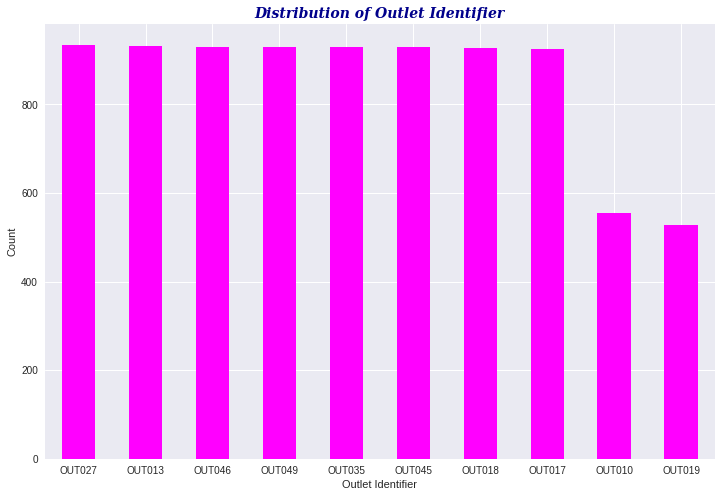

In [ ]:
plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }      
OID = sales_data['Outlet_Identifier'].value_counts()
OID.plot.bar(color='magenta', figsize=(12, 8))
plt.title('Distribution of Outlet Identifier', fontdict=font)
plt.xticks(rotation=0)
plt.xlabel('Outlet Identifier')
plt.ylabel('Count')
plt.show()

***Impact of Outlet Identifier on Item Sales***

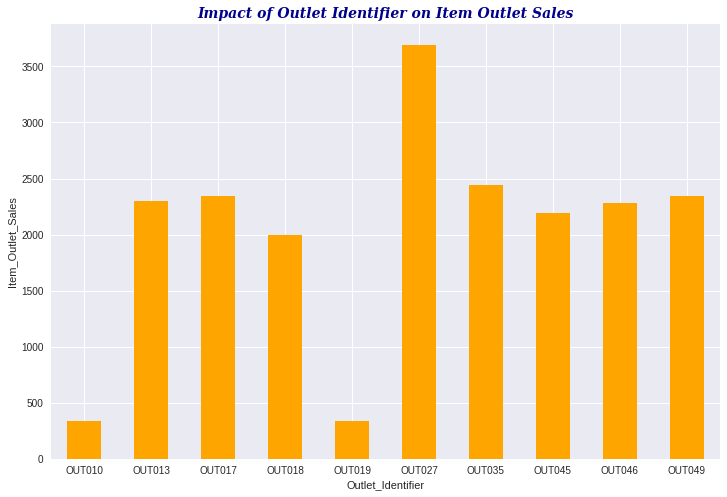

In [ ]:
plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
OID_sales =sales_data.groupby('Outlet_Identifier')[['Item_Outlet_Sales']].mean()
OID_sales.plot.bar(color='orange', figsize=(12, 8))
plt.legend('')
plt.title('Impact of Outlet Identifier on Item Outlet Sales', fontdict=font)
plt.xticks(rotation=0)
plt.ylabel('Item_Outlet_Sales')
plt.show()

From the bar chart above, we can see that Outlet027 has the highest sales among the 10 stores which have been identified. Except the two outlets Outlet010 and Outlet019 which have lesser sales, the rest have similar medium sales.

To identify the types of these oulets, we can make use of the pivot_table() function which is used to group them in a shreadsheet-style table based on frequency.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

In [ ]:
sales_data.pivot_table(values='Outlet_Type', columns='Outlet_Identifier', aggfunc=lambda x: x.mode())

Outlet_Identifier,OUT010,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049
Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type1,Supermarket Type2,Grocery Store,Supermarket Type3,Supermarket Type1,Supermarket Type1,Supermarket Type1,Supermarket Type1


***Distribution of different types of items by the store size***

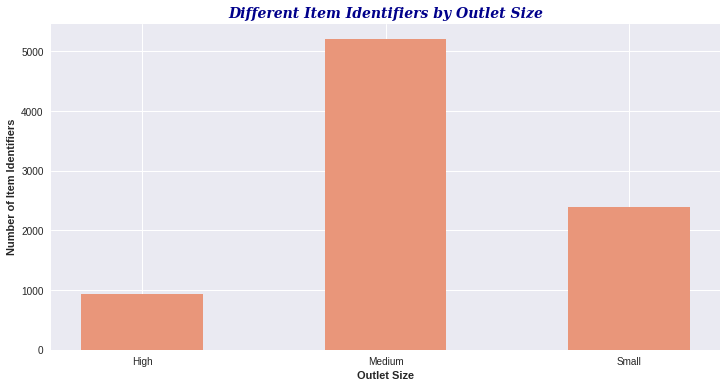

In [ ]:
# Number of different item identifiers by the store size
# Reference 1: https://pythonbasics.org/matplotlib-bar-chart/
# Reference 2: https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
# Reference 3: https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/
plt.style.use('seaborn')
sales_data.groupby('Outlet_Size')['Item_Identifier'].count()
x = sales_data.groupby('Outlet_Size')['Item_Identifier'].count().index
y = sales_data.groupby('Outlet_Size')['Item_Identifier'].count().values
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
plt.figure(figsize=(12, 6))       
plt.bar(x, y, color='darksalmon', width=0.5)
plt.title('Different Item Identifiers by Outlet Size', fontdict=font)
plt.xlabel('Outlet Size', fontweight='bold')
plt.ylabel('Number of Item Identifiers', fontweight='bold')
plt.show()


From the graph above, we can see that there are more number of different items in the small and medium-sized stores than in the high-sized ones. 

***Distribution of Item Fat Contents***

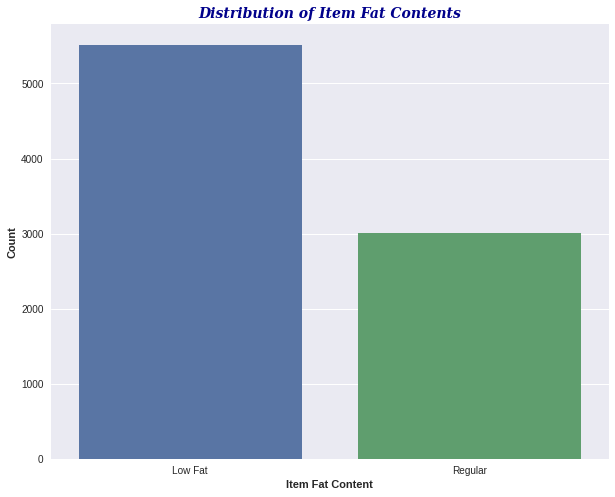

In [ ]:
plt.style.use('seaborn')
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
plt.figure(figsize=(10, 8))       
sns.countplot(sales_data['Item_Fat_Content'])
plt.title('Distribution of Item Fat Contents', fontdict=font)
plt.xlabel('Item Fat Content', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.show()

In [ ]:
# Different varieties of fats in food items by the Outlet Type
# Reference: https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/
# https://kontext.tech/column/code-snippets/399/pandas-dataframe-plot-bar-chart

fats = sales_data.groupby('Outlet_Size')['Item_Fat_Content'].value_counts()
fats


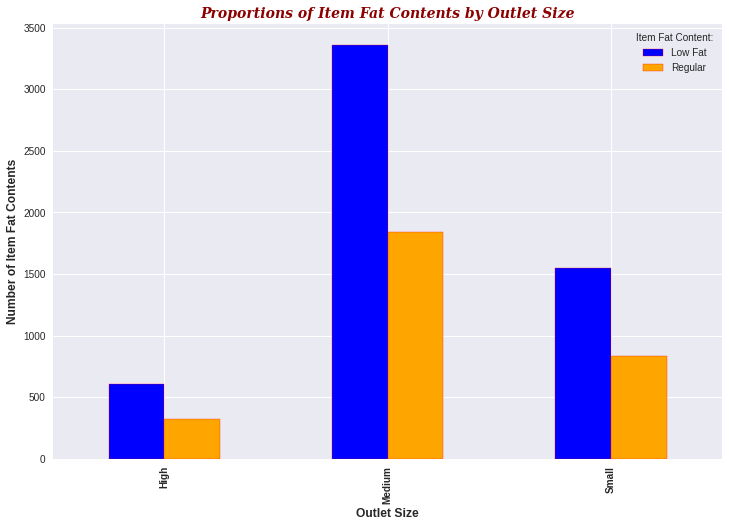

In [ ]:
# Reference 1: https://kontext.tech/column/code-snippets/399/pandas-dataframe-plot-bar-chart
# Reference 2: https://stackoverflow.com/questions/30873523/how-can-i-change-the-color-of-a-grouped-bar-plot-in-pandas
# Reference 3: https://www.datasciencemadesimple.com/bar-plot-bar-chart-in-python-legend-using-matplotlib/

fats.unstack().plot(kind='bar', color=['blue', 'orange'], edgecolor='red', figsize=(12, 8))
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkRed'
        }
plt.xlabel('Outlet Size', fontsize=12, fontweight='bold')
plt.ylabel('Number of Item Fat Contents', fontsize=12, fontweight='bold')
plt.xticks(fontweight='bold')
plt.title('Proportions of Item Fat Contents by Outlet Size', fontdict=font)
plt.legend(['Low Fat', 'Regular'], title='Item Fat Content:', fontsize=10)
plt.show()


From the two graphs above, we can see that there are more low fat food products available in the store.

***Plotting boxplots***

Graph boxplots to show the distribution of the continuous Item Outlet Sales feature for the different types of Outlet Location.

In [ ]:
tier1 = sales_data['Outlet_Location_Type'] == 'Tier 1'
sales_data[tier1]

In [ ]:
tier2 = sales_data['Outlet_Location_Type'] == 'Tier 2'
sales_data[tier2]

In [ ]:
tier3 = sales_data['Outlet_Location_Type'] == 'Tier 3'
sales_data[tier3]

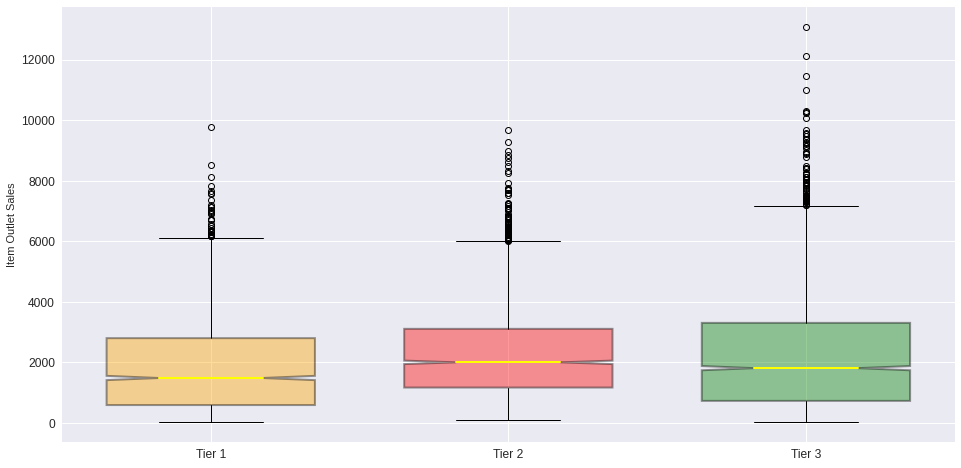

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

x1 = sales_data[tier1]['Item_Outlet_Sales'].values
x2 = sales_data[tier2]['Item_Outlet_Sales'].values
x3 = sales_data[tier3]['Item_Outlet_Sales'].values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
boxplots = ax.boxplot([x1, x2, x3], 
           labels=['Tier 1', 'Tier 2', 'Tier 3'], 
           notch =True,
           widths = 0.7,
           patch_artist =True,
           medianprops = dict(linestyle ='-', linewidth=2, color='yellow'),
           boxprops = dict(linestyle ='--', linewidth=2, color='black', facecolor='blue', alpha=0.4)
           )

boxplot1 = boxplots['boxes'][0]
boxplot2 = boxplots['boxes'][1]
boxplot3 = boxplots['boxes'][2]
boxplot1.set_facecolor('orange')
boxplot2.set_facecolor('red')
boxplot3.set_facecolor('green')


ax.set_ylabel('Item Outlet Sales')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

From the boxplots, we can see that the median of the sales increases as the cities are getting less populated even though there is a hypothesis that stores located in densely populated urban areas should have higher sales because of more demand and the presence of wealthy people.

##**Feature Engineering and Data Modeling** 

***Combining the different item identifiers:***

Within the Item_Type column, there are 16 different categories which can be very useful in our analysis. Hence, it is a good idea to combine them into 3 broad types: Food, Drinks and Non-Consumable. The unique ID(Item_Identifier) of each item starts with either FD for Food, DR for Dinks or NC for Non-Consumables. Once this is done, a separate fat-content category should be specified for the non-consumable items; otherwise, it does not make sense.


In [ ]:
sales_data['Item_Type_Combined'] = sales_data['Item_Identifier'].apply(lambda x: x[0:2])
sales_data['Item_Type_Combined'] = sales_data['Item_Type_Combined'].map({'FD': 'Food', 'DR': 'Drinks', 'NC': 'Non-Consumable'})
sales_data['Item_Type_Combined'].unique()


array(['Food', 'Drinks', 'Non-Consumable'], dtype=object)

In [ ]:
# Now drop the Item_Identifier and Item_Type columns
sales_data = sales_data.drop(columns=['Item_Identifier', 'Item_Type'])

In [ ]:
# Mark the non-consumable items as 'Non-Edible' in the Item_Fat_Content
sales_data.loc[sales_data['Item_Type_Combined'] == "Non-Consumable", "Item_Fat_Content"] = "Non-Edible"
sales_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'Non-Edible'], dtype=object)

***Modifying the Item_Visibility:***

From the data exploration and visualization process, we saw that items which are not visible to the customers have the highest sales. The minimum value for the Item_Visibility variable is equal to 0, which makes no practical sense because when a item is being sold in a store, visibility cannot be 0. So I will consider it as missing information and impute it with mean visibility of that item. 

In [ ]:
sales_data['Item_Visibility'] = sales_data['Item_Visibility'].replace(0, 'NaN')
sales_data = sales_data.astype({'Item_Visibility': float})
sales_data['Item_Visibility'] = sales_data['Item_Visibility'].fillna(sales_data['Item_Visibility'].mean())

sales_data['Item_Visibility'].value_counts()

***Separating categorical and numerical variables:***

Split the columns of the data into numerical and categorical variables. Then drop the year of Outlet establishment as it has no that much significant impact on the sales.


In [ ]:
categorical_variables = sales_data.select_dtypes(include=object)
categorical_variables.head()

,Item_Fat_Content,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Combined
0,Low Fat,OUT049,Medium,Tier 1,Supermarket Type1,Food
1,Regular,OUT018,Medium,Tier 3,Supermarket Type2,Drinks
2,Low Fat,OUT049,Medium,Tier 1,Supermarket Type1,Food
3,Regular,OUT010,Medium,Tier 3,Grocery Store,Food
4,Non-Edible,OUT013,High,Tier 3,Supermarket Type1,Non-Consumable


In [ ]:
numerical_variables = sales_data.select_dtypes(include=['float64', 'int64'])
numerical_variables = numerical_variables.drop(columns='Outlet_Establishment_Year')
numerical_variables.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
0,9.30,0.016047,249.8092,3735.1380
1,5.92,0.019278,48.2692,443.4228
2,17.50,0.016760,141.6180,2097.2700
3,19.20,0.070482,182.0950,732.3800
4,8.93,0.070482,53.8614,994.7052


In [ ]:
# Method 2
numerical_variables = sales_data.select_dtypes(exclude=object)
numerical_variables = numerical_variables.drop(columns='Outlet_Establishment_Year')
numerical_variables.head()

***Tranforming categorical variables into numerical format using Dummy Label***


In [ ]:
categorical_variables = pd.get_dummies(categorical_variables, drop_first=True)
categorical_variables.head()

,Item_Fat_Content_Non-Edible,Item_Fat_Content_Regular,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Type_Combined_Food,Item_Type_Combined_Non-Consumable
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1


In [ ]:
# Combine the encoded categorial variables and numerical variables 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

combined_data = pd.concat([categorical_variables, numerical_variables], axis=1)
combined_data.head()

**Method 2 -Encoding**: 

Instead of using the Dummy Encoding scheme, we can use **LabelEncoder** and **OneHotEncoder** schemes.

In [ ]:
# Transforming categorical variables into numerical labels 
encoder = LabelEncoder()
encodedLabels = categorical_variables.apply(encoder.fit_transform)
encodedLabels

# Creating dummy variables or features for each category using One-hot Encoding scheme
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
ohe = OneHotEncoder()
encodedLabels_array = ohe.fit_transform(encodedLabels).toarray()
encodedLabels_array

# Get column names for the dummy variables 
column_names = ohe.get_feature_names(['Item_Fat_Content',	'Item_Type',	'Outlet_Identifier',	'Outlet_Size',	'Outlet_Location_Type',	'Outlet_Type'])
column_names

# Convert the enconded labels array into Pandas dataframe 
categorical_variables = pd.DataFrame(data=encodedLabels_array, columns=column_names)
categorical_variables

# Combine the encoded categorial variables and numerical variables 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

combined_data = pd.concat([categorical_variables, numerical_variables], axis=1)
combined_data.head()


***Split the data into feature matrix and target vector***

In [ ]:
X = combined_data.drop('Item_Outlet_Sales', axis = 1).values
y = combined_data['Item_Outlet_Sales'].values

##**Linear Regression Model**

In [ ]:
# Splitting data into train and test for predictions.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [ ]:
# Make an instance of the model and fit the data onto the model
regmodel = LinearRegression(fit_intercept=True)
regmodel.fit(X_train, y_train)

In [ ]:
# Make predictions for the previously unseen data 
predictions_testing = regmodel.predict(X_test)
predictions_testing

array([2882.88406001, 2038.1490483 ,  542.64855027, ..., 4217.52503753,
       2635.11800631, 1856.37936493])

***Evaluating the Linear Regression model performance***

By comparing the training and testing scores, we need to make sure that our linear regression data model is not over fit.

In [ ]:
# Coefficient of Determination R-Squared of the prediction
score_training = regmodel.score(X_train, y_train)
score_testing = regmodel.score(X_test, y_test)

print("score_training:", score_training)
print("score_testing:", score_testing)

score_training: 0.5544536260526491
score_testing: 0.5900393833521596


In [ ]:
# Method 2
score_training = r2_score(y_train, regmodel.predict(X_train))
score_testing = r2_score(y_test, predictions_testing)

print("score_training:", score_training)
print("score_testing:", score_testing)

score_training: 0.5544536260526491
score_testing: 0.5900393833521596


In [ ]:
# Root Mean Squared Error 
RMSE_training = mean_squared_error(y_train, regmodel.predict(X_train), squared=False)
RMSE_testing = mean_squared_error(y_test, predictions_testing, squared=False)

print("RMSE_training:", RMSE_training)
print("RMSE_testing:", RMSE_testing)

RMSE_training: 1139.8109171305882
RMSE_testing: 1090.253268820084


##**KNN Regressor Model**

In [ ]:
# Splitting data into train and test for predictions.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [ ]:
# Scaling the data -fit only training set and transform both sets
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

*Find the optimal number of neighbors before creating the KNN model.*

In [ ]:
neighbors_range = [1] + list(range(5, 300, 10)) # A list of k-nearest neighbors to try
performance_values = [] # A list to store the performance scores 

for neighbors in neighbors_range:
  knn = KNeighborsRegressor(n_neighbors=neighbors)
  knn.fit(X_train_scaled, y_train)
  score = knn.score(X_test_scaled, y_test)
  performance_values.append(score)

In [ ]:
# Change performance values and the neighbors range into a dataframe table 
df_performance = pd.DataFrame({'k-neighbors': neighbors_range, 'performance_value': performance_values})
df_performance.sort_values(by='performance_value', ascending=False)

,k-neighbors,performance_value
3,25,0.589001
2,15,0.586459
4,35,0.578769
5,45,0.573069
6,55,0.568353
7,65,0.561369
8,75,0.551711
9,85,0.543326
1,5,0.541715
10,95,0.531403


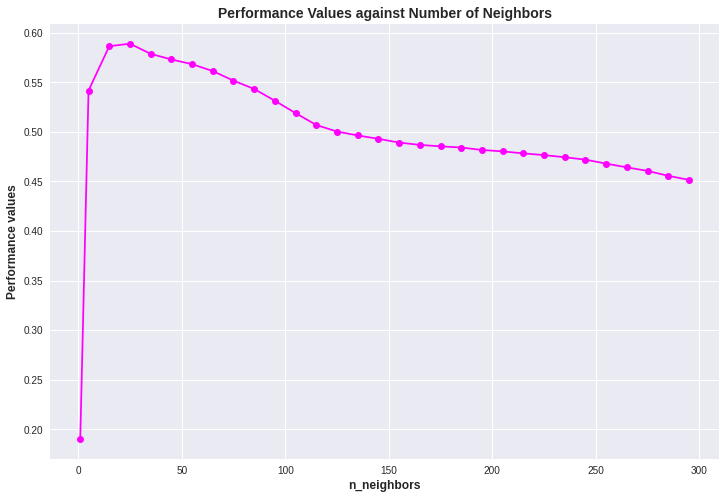

In [ ]:
# Plot the average performance values against the neighbors range,
# and determine the optimal number of neighbors 
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.plot(neighbors_range, performance_values, marker='o', color='magenta')
ax.set_title('Performance Values against Number of Neighbors', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_xlabel('n_neighbors', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_ylabel('Performance values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.show()

From the graph above and perfomance values obtained by the Python code, we can see that the optimal number of neighbors which can give us the best model is n_neighbors=25. This is diffrent from the default number of  neighbors, which is equal to 5.

In [ ]:
# Instantiate the KNN model and fit it with the dataset
knnmodel = KNeighborsRegressor(n_neighbors=25)
knnmodel.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions for the testing set
predictions_knn_testing = knnmodel.predict(X_test_scaled)
predictions_knn_testing

array([2888.453456, 2004.45748 , 1339.003696, ..., 3781.664104,
       2716.33084 , 1827.567736])

***Evaluating the KNN Regressor model performance***

In [ ]:
# Coefficient of Determination R-Squared of the prediction
score_knn_training = knnmodel.score(X_train_scaled, y_train)
score_knn_testing = knnmodel.score(X_test_scaled, y_test)

print("score_knn_training:", score_knn_training)
print("score_knn_testing:", score_knn_testing)

score_knn_training: 0.5870112626717922
score_knn_testing: 0.5890014065072519


In [ ]:
# Root Mean Squared Error 
RMSE_knn_training = mean_squared_error(y_train, knnmodel.predict(X_train_scaled), squared=False)
RMSE_knn_testing = mean_squared_error(y_test, predictions_knn_testing, squared=False)

print("RMSE_knn_training:", RMSE_knn_training)
print("RMSE_knn_testing:", RMSE_knn_testing)

RMSE_knn_training: 1097.376004638942
RMSE_knn_testing: 1091.6325991731178


##**Random Forest Regressor**

In [ ]:
# Splitting data into train and test for predictions.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

*Find the optimal number of neighbors before creating the Random Forest Regressor model.*

In [ ]:
estimators_range = [1] + list(range(10, 600, 50)) # A list of number of estimators to try
performance_scores = [] # A list to store the performance scores 

for estimators in estimators_range:
  rfg = RandomForestRegressor(n_estimators=estimators)
  rfg.fit(X_train, y_train)
  score = rfg.score(X_test, y_test)
  performance_scores.append(score)

In [ ]:
# Change performance values and the estimators range into a dataframe table 
df_performance = pd.DataFrame({'n_estimators': estimators_range, 'performance_score': performance_scores})
df_performance.sort_values(by='performance_score', ascending=False)

,n_estimators,performance_score
12,560,0.570210
8,360,0.570206
6,260,0.569930
9,410,0.569082
11,510,0.568364
10,460,0.567307
7,310,0.567025
2,60,0.565658
5,210,0.565254
4,160,0.565211


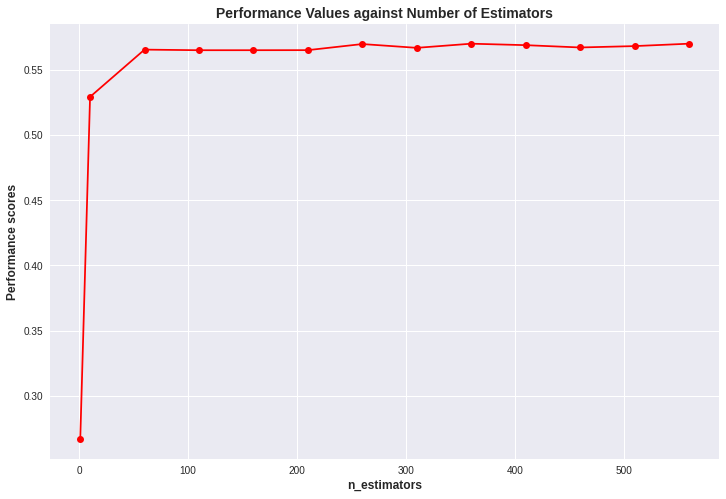

In [ ]:
# Plot the average performance values against the estimators range,
# and determine the optimal number of estimators 
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.plot(estimators_range, performance_scores, marker='o', color='red')
ax.set_title('Performance Values against Number of Estimators', fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_xlabel('n_estimators', fontdict={'fontsize': 12, 'fontweight': 'bold'})
ax.set_ylabel('Performance scores', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.show()

From the graph above and perfomance values obtained by the Python code, we can see the performance score increases as the number of estimators increases. As the performance does not hold if we do not tune other hyperparameters. I have found n_estimators=500 to be the optimal value by tuning the max_depth and min_samples_leaf. Remember that the default n_estimators is equal to 100.

In [ ]:
# Make an instance of the Random Forest Regressor model and fit it with dataset
rfgmodel = RandomForestRegressor(n_estimators=500, max_depth=6, min_samples_leaf=50)
rfgmodel.fit(X_train, y_train)

In [ ]:
# Make new predictions 
predictions_rfg_testing = rfgmodel.predict(X_test)
predictions_rfg_testing

array([2882.70261856, 1949.0348588 ,  622.07058364, ..., 4270.25073604,
       2773.20575714, 1715.61211552])

***Evaluating the Random Forest Regressor model performance***

In [ ]:
# Coefficient of Determination R-Squared of the prediction
score_rfg_training = rfgmodel.score(X_train, y_train)
score_rfg_testing = rfgmodel.score(X_test, y_test)

print("score_rfg_training:", score_rfg_training)
print("score_rfg_testing:", score_rfg_testing)

score_rfg_training: 0.6087463007379363
score_rfg_testing: 0.6223139819671555


In [ ]:
# Root Mean Squared Error 
RMSE_rfg_training = mean_squared_error(y_train, rfgmodel.predict(X_train), squared=False)
RMSE_rfg_testing = mean_squared_error(y_test, predictions_rfg_testing, squared=False)

print("RMSE_rfg_training:", RMSE_rfg_training)
print("RMSE_rfg_testing:", RMSE_rfg_testing)

RMSE_rfg_training: 1068.109023283575
RMSE_rfg_testing: 1046.457951594882


##**Conclusions**
From the model performance analysis, we can see that all of the models are not overfit since they perform better on the previously unseen data. In other words, in all of the cases the testing performance scores are higher than those of the training ones. However, KNN model seems to be a little bit more consistent because the training score and testing score are closer together. But of all, the Random Forest Regressor is the best model it seems to be performing well on the testing data subset, which is what the model is meant for.

Additionally, the calculated results of the error metrics are also inline with the performance scores of the models. We have comparatively less errors in the testing dataset. 
